In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Tắt cảnh báo cho gọn
import warnings
warnings.filterwarnings('ignore')

1. Load & Clean Data

In [2]:
df = pd.read_csv("./Outputs/final.csv", header=0)
print(f"Original data shape: {df.shape}")

Original data shape: (2055, 12)


2. Process when No Detection (Face & Pose)

In [3]:
df_filtered = df.drop(columns=["Image_Path"])
print(f"Filtered data shape: {df_filtered.shape}")

mask_no_face = (df['FACIAL_DISPLAYED'] == 0)
mask_no_pose = (df['POSE_DISPLAYED'] == 0)

Filtered data shape: (2055, 11)


Label as Passed_out when cannot detect face / pose


In [4]:
df_filtered.loc[(mask_no_face & mask_no_pose) | (mask_no_face), 'LABEL'] = 3

print(f"Rows labeled as 'No Detection' (Label 3): {df_filtered[df_filtered['LABEL'] == 3].shape[0]}")

Rows labeled as 'No Detection' (Label 3): 237


Seperate Feature & Label

In [5]:
# Drop unnecessary column
X = df.drop(columns=['EYE_CL', 'FACIAL_DISPLAYED', 'POSE_DISPLAYED', 'Image_Path', 'LABEL'])
y = df['LABEL']

2. Preprocessing

Split Data

In [6]:
# Split into Train (70%), Validation (15%), and Test (15%)
# Stratify ensures we have examples of Label 3 in all sets
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

Scale Data

In [7]:
# Scale the features using StandardScaler()
scaler = StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)


In [8]:
from imblearn.over_sampling import SMOTE
# 1. Set up SMOTE
# sampling_strategy = 'auto' resamples all classes to match the majority class

# 2. Resample X and y

print(f"Original shape: {pd.Series(y_train_raw).value_counts().to_dict()}")

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_raw)

print(f"New shape after SMOTE: {pd.Series(y_train_resampled).value_counts().to_dict()}")


Original shape: {2: 620, 1: 357, 0: 295, 3: 166}
New shape after SMOTE: {1: 620, 0: 620, 2: 620, 3: 620}


One-hot Encoding

In [9]:
# Numnber of classes (0: Awake, 1: Sleep, 2: Yawn, 3: Passed_out)
num_classes = 4
y_train_final = to_categorical(y_train_resampled, num_classes)
y_val_final = to_categorical(y_val_raw, num_classes)
y_test_final = to_categorical(y_test_raw, num_classes)


X_train = X_train_resampled
y_train = y_train_final

X_val = X_val_scaled
y_val = y_val_final

X_test = X_test_scaled
y_test = y_test_final

Calculate Class Weight

In [10]:
# # Balancing datasets
# # y_integers = np.argmax(y_train, axis = 1)
# class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y_integers), y=y_integers)
# class_weights_dict = dict(enumerate(class_weights))
# print("Class Weights: ", class_weights_dict)

3. Train Model

In [11]:
def build_and_train_model(num_nodes, dropout_prob, lr, batch_size, epochs):
    model = Sequential([
        Dense(num_nodes, activation='relu', input_shape =(X_train.shape[1],)),
        BatchNormalization(), # More stable for training
        Dropout(dropout_prob),
        Dense(num_nodes // 2, activation='relu'), # Second hidden smaller layer
        BatchNormalization(),
        Dropout(dropout_prob),
        Dense(num_classes, activation='softmax') # Use softmax for multi-class classification
    ])

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data = (X_val, y_val),
        epochs = epochs,
        batch_size=batch_size,
        #class_weight=class_weights_dict,
        callbacks=[early_stop],
        verbose = 0 # Silent training
    )
    return model, history

4. Grid Search (Manually)

In [12]:
# Smaller scale for faster
node_counts = [16, 32, 64, 128]
dropout_probs = [0.2, 0.4]
learning_rates = [0.01, 0.001] # Gold value for Adam, rarely change
batch_sizes = [16, 32, 64, 128]

best_val_loss = float('inf')
best_model = None
best_config = {}

total_runs = len(node_counts) * len(dropout_probs) * len(learning_rates) * len(batch_sizes)
current_run = 0

print(f"Start GRID SEARCH ({total_runs} combinations...)")

for nodes in node_counts:
    for drop in dropout_probs:
        for lr in learning_rates:
            for batch in batch_sizes:
                current_run += 1
                print(f"\n[{current_run} / {total_runs}] Train: Nodes = {nodes} | Drop = {drop} | LR = {lr} | Batch = {batch}...", end="")

                model, history = build_and_train_model(nodes, drop, lr, batch, epochs = 150)

                val_loss = min(history.history['val_loss'])
                val_acc = max(history.history['val_accuracy'])

                print(f"\nVal Loss = {val_loss:.4f} | Val Accuracy = {val_acc:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss=val_loss
                    best_model = model # Lưu trực tiếp object model vào RAM
                    best_config =   {'nodes': nodes, 'drop': drop, 'lr': lr, 'batch': batch}
                    print(f"Found Best Model | (Val Loss: {best_val_loss:.4f})")

print(f"\nBest Config: {best_config}")
print(f"Best Val Loss: {best_val_loss:.4f}")

print(f"Training model with best cofig: {best_config}")

# Gọi lại hàm train với các tham số từ best_config
final_model, final_history = build_and_train_model(
    num_nodes=best_config['nodes'],
    dropout_prob=best_config['drop'],
    lr=best_config['lr'],
    batch_size=best_config['batch'],
    epochs=150 # Chạy đủ số epoch để thấy rõ biểu đồ
)

print("Training Done, ploting...")

Start GRID SEARCH (64 combinations...)

[1 / 64] Train: Nodes = 16 | Drop = 0.2 | LR = 0.01 | Batch = 16...
Val Loss = 0.1057 | Val Accuracy = 0.9740
Found Best Model | (Val Loss: 0.1057)

[2 / 64] Train: Nodes = 16 | Drop = 0.2 | LR = 0.01 | Batch = 32...
Val Loss = 0.0890 | Val Accuracy = 0.9805
Found Best Model | (Val Loss: 0.0890)

[3 / 64] Train: Nodes = 16 | Drop = 0.2 | LR = 0.01 | Batch = 64...
Val Loss = 0.0868 | Val Accuracy = 0.9773
Found Best Model | (Val Loss: 0.0868)

[4 / 64] Train: Nodes = 16 | Drop = 0.2 | LR = 0.01 | Batch = 128...
Val Loss = 0.0939 | Val Accuracy = 0.9708

[5 / 64] Train: Nodes = 16 | Drop = 0.2 | LR = 0.001 | Batch = 16...
Val Loss = 0.1011 | Val Accuracy = 0.9708

[6 / 64] Train: Nodes = 16 | Drop = 0.2 | LR = 0.001 | Batch = 32...
Val Loss = 0.0938 | Val Accuracy = 0.9708

[7 / 64] Train: Nodes = 16 | Drop = 0.2 | LR = 0.001 | Batch = 64...
Val Loss = 0.1040 | Val Accuracy = 0.9740

[8 / 64] Train: Nodes = 16 | Drop = 0.2 | LR = 0.001 | Batch = 12

Ploting

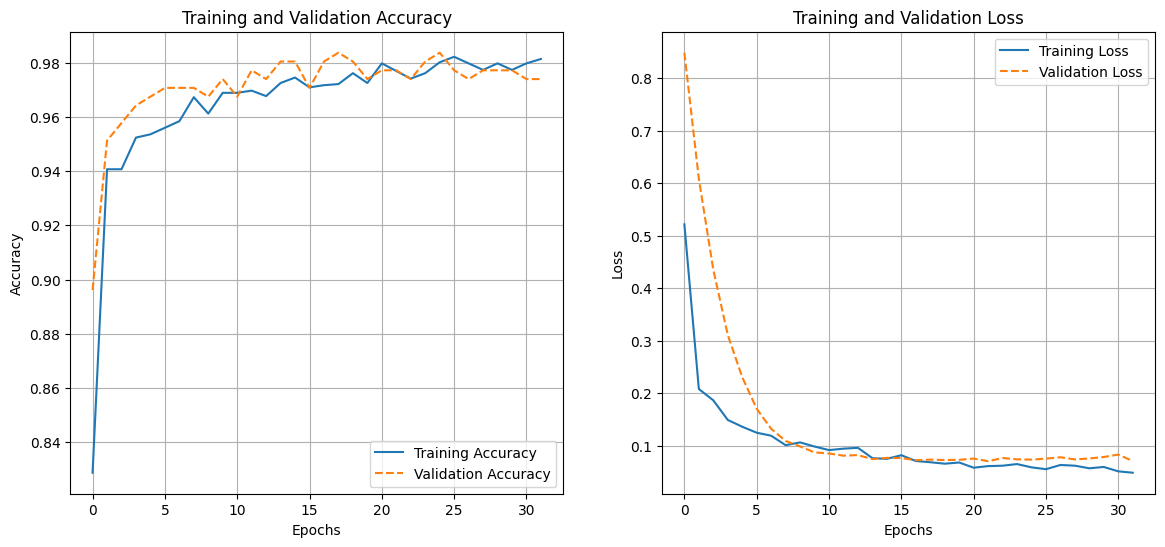

In [13]:
def plot_training_history(history):
    # Lấy dữ liệu từ history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    # --- BIỂU ĐỒ 1: ĐỘ CHÍNH XÁC (ACCURACY) ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='--')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # --- BIỂU ĐỒ 2: ĐỘ MẤT MÁT (LOSS) ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='--')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.show()

# Gọi hàm vẽ
plot_training_history(final_history)

5. Rate & Save

In [14]:
# Rating on Test Field
loss, acc, recall = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy on Test Field: {acc*100:.2f}%")

# Save Model
save_path = './Outputs/drowsiness_model_best.h5'
best_model.save(save_path)
print(f"Best model saved at: {save_path}")

# Save Scaler (for camera using)
with open('./Outputs/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved at ./Outputs/scaler.pkl")

Accuracy on Test Field: 97.41%
Best model saved at: ./Outputs/drowsiness_model_best.h5
Scaler saved at ./Outputs/scaler.pkl


Predict Value

In [15]:
y_pred_nn = best_model.predict(X_test)

#1. Convert Probabilities to Class Lables
# y_pred_nn = is likely shape (N,4) with probabilities, we take the index of the highest probabilities
y_pred_classes = np.argmax(y_pred_nn, axis=1)

# 2. Convert y_test to Class Labels (if it's one-hot-encoded)
# if y_test if shape (N,4), we also have argmax
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Classification Report

In [16]:
# 3. Print the Classification Report
# Define your class names for easier reading

class_names = ['Awake (0)', 'Drowsy(1)', 'Yawning (2)', 'Passed out (3)']
# Note: Double check your mapping! Usually 0 = Awake, 1 = Drowsy / Closed, 2 = Yawn, 3 = No Face

print(f"\n----- Classification Report -----")
print(classification_report(y_true, y_pred_classes, target_names = class_names)) 


----- Classification Report -----
                precision    recall  f1-score   support

     Awake (0)       0.95      0.97      0.96        64
     Drowsy(1)       0.97      0.97      0.97        77
   Yawning (2)       0.98      0.98      0.98       133
Passed out (3)       1.00      0.94      0.97        35

      accuracy                           0.97       309
     macro avg       0.98      0.97      0.97       309
  weighted avg       0.97      0.97      0.97       309



Confusion Matrix

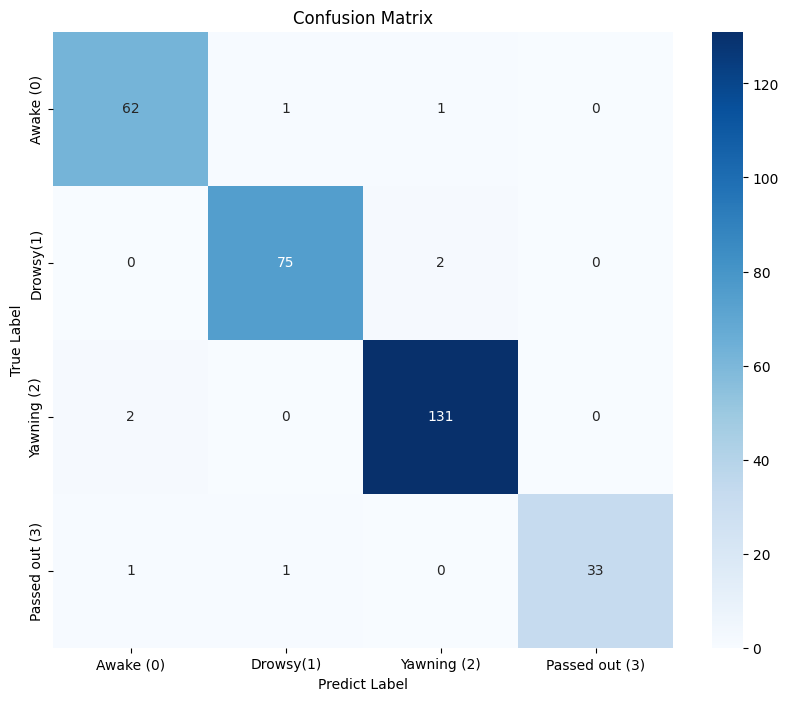

In [17]:
# 4. Generate and Plot Confusion Matrix

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predict Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()